We begin by importing various libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

We then create a neural network. Here we are creating 2 hidden layers, each with 128 neurons and using GELU as the activation function.

In [2]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 128, activation = 'gelu'),
    tf.keras.layers.Dense(units = 128, activation = 'gelu'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               256       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16897 (66.00 KB)
Trainable params: 16897 (66.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Consider the mass-spring with friction DE:
$$my''+by'+ky=0$$
Whose solutions are of the form
$$y(t)=Ae^{\alpha t}\sin(\beta t+\phi)$$

We then obtain the following $L_{phys}$
$$L_{phys}=\frac{1}{n}\sum_{i=1}^n (\hat{m}\hat{y}''+\hat{b}\hat{y}'+\hat{k}\hat{y})^2$$

Of course we also have our $L_{data}$, which is typical MSE
$$L_{data}=\frac{1}{n}\sum_{i=1}^n(y-\hat{y})$$

We then get our final loss $L$
$$L=w_{data}L_{data}+w_{phys}L_{phys}$$

In [3]:
data_weight = 1
phys_weight = 1

def ode_system(ttrain, ytrain, m, b, k, net):
    ttrain = ttrain.reshape(-1,1)
    ttrain = tf.constant(ttrain, dtype = tf.float32)

    with tf.GradientTape() as tape1:
        tape1.watch(ttrain)
        with tf.GradientTape() as tape2:
            tape2.watch(ttrain)

            yhat = net(ttrain)
            yhat_t = tape2.gradient(yhat, ttrain)
        yhat_t2 = tape1.gradient(yhat_t, ttrain)

    ode_loss = m * yhat_t2 + b * yhat_t + k * yhat
    mse_loss = yhat - ytrain

    square_loss = tf.square(mse_loss) * data_weight + tf.square(ode_loss) * phys_weight
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

We then create some synthetic training data to train our model on. We also add some noise into our data.

In [4]:
# Generate training data from known values
train_t = np.linspace(0, 5, 20).reshape(-1, 1)
train_y = (5 / np.sqrt(2)) * np.exp(-1 * train_t) * np.sin(np.sqrt(2) * train_t)
# Add some noise to the data
for train_y_cur in train_y:
    train_y_cur += 0.2 * random.random() - 0.1

And we perform the actual training to determine the model and the values of $m$, $b$, and $k$.

0.47942185
0.03181284
0.007675131
0.0033227443
0.0029284093


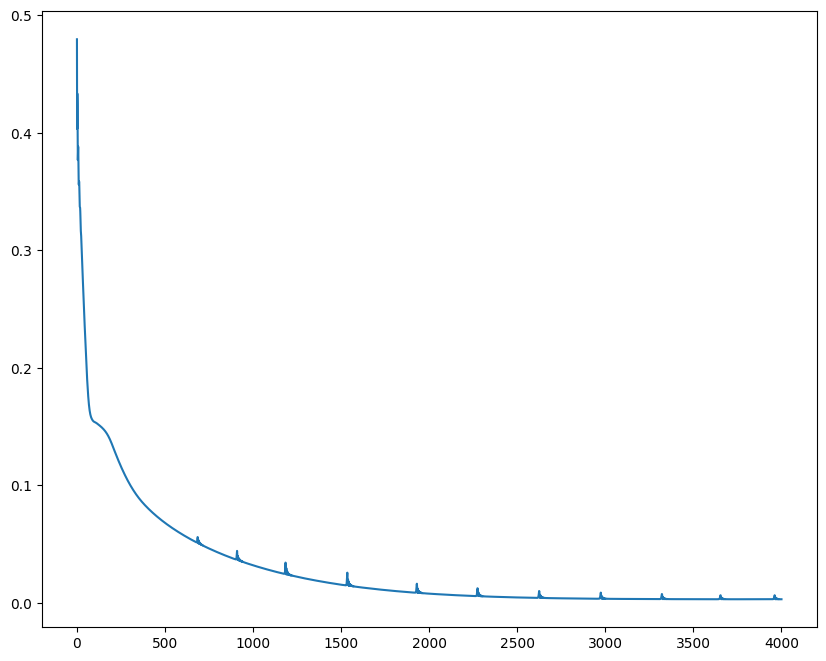

In [5]:
m = tf.Variable(initial_value=1.0,trainable=False, dtype=tf.float32)
b = tf.Variable(initial_value=2.0,trainable=False, dtype=tf.float32)
k = tf.Variable(initial_value=1.0,trainable=True, dtype=tf.float32)

optm = tf.keras.optimizers.Adam(learning_rate = 0.001)
train_loss_record = []

# Train the model
for itr in range(4001):
    with tf.GradientTape() as tape1:
        train_loss = ode_system(train_t, train_y, m, b, k, NN)
        train_loss_record.append(train_loss)

        grad_w = tape1.gradient(train_loss, NN.trainable_variables + [k])
        optm.apply_gradients(zip(grad_w, NN.trainable_variables + [k]))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

We also plot the model against the true solution.

The true solution to the IVP with $m=1, b=2, k=3, y(0)=0, y'(0)=5$ is
$$y(t)=\frac{5}{\sqrt{2}}e^{-t}\sin(\sqrt{2}t)$$

4/4 [==============================] - 0s 5ms/step
m: 1 b: 2 k: 3.02552605


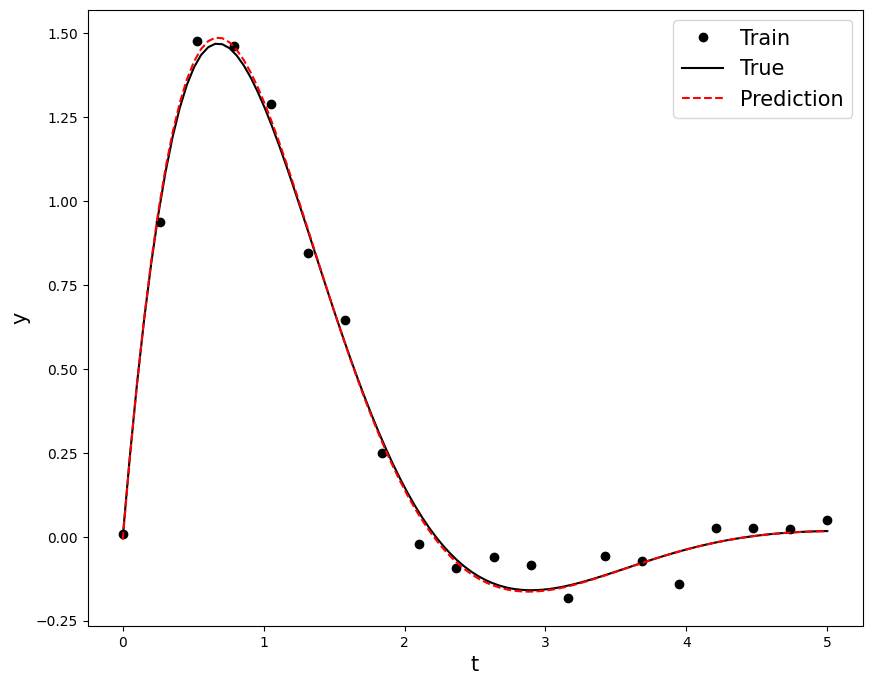

In [6]:
# Test the model
test_t = np.linspace(0, 5, 100)
true_y = (5 / np.sqrt(2)) * np.exp(-1 * test_t) * np.sin(np.sqrt(2) * test_t)
pred_y = NN.predict(test_t).ravel()

tf.print("m:", m, "b:", b, "k:", k)

plt.figure(figsize = (10,8))
plt.plot(train_t, train_y, 'ok', label = 'Train')
plt.plot(test_t, true_y, '-k',label = 'True')
plt.plot(test_t, pred_y, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('y', fontsize = 15)
plt.show()